In [1]:
#Criado por: Vinícius de Almeida Nery Ferreira (ECO - UnB)
#Github: https://github.com/vnery5/Econometria

#######################################################################################################################
###COMO USAR AS FUNÇÕES EM UM NOTEBOOK
##Antes, copie e cole todos os imports e definições daqui na primeira célula do notebook e pressione Shift + Enter
##Para coletar os dados do arquivo "carros.dta" (só funciona com arquivos .dta):
#coletar_dados("carros")

## Exportar resultados como imagem ou texto: https://stackoverflow.com/questions/46664082/python-how-to-save-statsmodels-results-as-image-file
#######################################################################################################################

##Importando os pacotes e módulos necessários
import pandas as pd
import numpy as np
import math

#Para Regressão Linear Simples e Teste F
from scipy import stats

#Para Regressão Linear Múltipla (OLS, GLS e WLS) e Testes Estatísticos
import statsmodels.api as sm
import econtools
import econtools.metrics as mt

#Para Regressão em Painel e IV
from linearmodels import PanelOLS, FirstDifferenceOLS, PooledOLS, RandomEffects
from linearmodels.panel import compare
from linearmodels.iv import IV2SLS

#Pacotes para gráficos (caso precise)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Pacotes para fazer a coleta dos dados armazenados no mesmo diretório e outros pacotes gerais
import os
import pathlib
import glob
from IPython.display import clear_output
import gc
import subprocess #permite a cópia para o clipboard das equações gerados com as funções equation()

####################################### Criando as Funções ###############################################################

def coletar_dados(nome = ""):
    '''
    Função que le os arquivos do Stata (.dta) - NÃO COLOQUE A EXTENSÃO NA HORA DE NOMEAR O "NOME"!
    O arquivo deve estar na mesma pasta do arquivo de Python ou do notebook do jupyter.
    Deixe em branco para ler o arquivo mais recentemente adicionado à pasta.
    '''

    global df

    #Pegando qual a pasta do arquivo que está sendo usado pra programar
    caminho = pathlib.Path().absolute()

    #No meu caso específico:
    caminho_vinicius = f"{caminho}/datasets"

    #checando se o nome foi inserido ou não; caso não, pegar o arquivo .dta mais recente
    if nome == "":
        try:
            arquivo = max(glob.glob(f"{str(caminho)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
        except:
            arquivo = max(glob.glob(f"{str(caminho_vinicius)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
    else:
        try:
            arquivo = f"{str(caminho)}/{str(nome)}.dta"
            df = pd.read_stata(arquivo)
            print(f"{nome}.dta foi lido com sucesso!")
            return df
        except:
            try:
                arquivo = f"{str(caminho_vinicius)}/{str(nome)}.dta"
                df = pd.read_stata(arquivo)
                print(f"{nome}.dta foi lido com sucesso!")
                return df
            except: #caso não tenha sido encontrado o arquivo com o nome inserido
                print('''
                Não foi possível achar o arquivo :(\n
                Verifique se seu nome está correto (sem a extensão) e se ele está no mesmo diretório do programa!
                ''')

def Regressao_Multipla(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla, sendo, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares (OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de erros padrão
    Modelo = sm.OLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster" or cov == "clustered":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            erro = "Não foi possível encontrar o grupo selecionado. Tente novamente!"
            return erro
    else:
        Resultado = Modelo.fit()
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(Resultado.summary())

    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}")
    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade.
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )

def Regressao_MQP(x, y, pesos, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados ponderados, ou seja,
    recomendada quando o erro é heteroscedástico E se sabe a função da constante. Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    pesos: 1/h, sendo h a constante multiplicativa da variância do erro (ou seja, sem a raiz);
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares(OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de erros padrão
    Modelo = sm.WLS(y,X, weights = pesos)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster" or cov == "clustered":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            erro = "Não foi possível encontrar o grupo selecionado. Tente novamente!"
            return erro
    else:
        Resultado = Modelo.fit()

    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}\n")
    print(Resultado.summary())

    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )
    
def Regressao_MQGF(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados generalizados factíveis, ou seja,
    recomendada quando o erro é heteroscedástico E NÃO se sabe a função da constante multiplicativa da variância do erro, sendo os pesos estimados
    regridindo o log dos quadrados dos resíduos sobre as variáveis explicativas. Os estimadores MQP são gerados com o peso estimado.
    Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #Regredindo os valores normalmente a fim de pegar os resíduos
    Regressao_Multipla(x,y, constante, cov)
    clear_output()

    #Coletando o log dos quadrados dos resíduos
    Log_Res_Quad = np.log(Resíduos**2)

    #Regredindo Log_Res_Quad sobre as variáveis explicativas
    Regressao_Multipla(x,Log_Res_Quad, constante, cov)
    clear_output()

    #Estimando os pesos
    Pesos = np.exp(Lista_ychapeu)

    #Fazendo uma Regressão MQP
    Regressao_MQP(x,y, 1/Pesos, constante, cov)

def Teste_LM(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste LM e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)
    
    #Fazendo a regressão do modelo restrito e armazenando os resíduos
    Regressao_Multipla(df[ModeloRestrito], y)
    Resíduos_r = Resíduos

    #Fazendo a regressão dos resíduos sobre as variáveis independentes e armazenando o R2
    Regressao_Multipla(x, Resíduos_r)
    Ru = Resultado.rsquared

    #Calculando a estatística LM
    LM = Numero_de_Observações*Ru

    #Calculando o p-valor
    ##Calculando o P-valor de F
    P_valor = stats.chi2.sf(LM,GL_r)

    #Limpando a tela
    clear_output()

    #Printando o resultado
    if Nivel_de_Significância > P_valor:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho a um nível de significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho a um nível de significância de {Nivel_de_Significância*100}%.")


def Teste_F(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    #para testar igualdade dos coeficientes, F2, p_valueF2 = results.Ftest(['ACT', 'skipped'], equal=True)
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_ir = Numero_de_Observações - (len(ModeloIrrestrito) + 1)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)

    ##Fazendo as regressões de cada modelo
    Regressao_Multipla(x, y)
    SQR_ir = SQR
    VarianciaReg_ir = EPR**2

    Regressao_Multipla(df[ModeloRestrito], y)
    SQR_r = SQR

    #Limpando a tela
    clear_output()
    
    ##Calculando F
    F = (SQR_r - SQR_ir)/(len(Restrições)*VarianciaReg_ir)

    ##Calculando o P-valor de F
    P_valor = stats.f.sf(F,GL_r,GL_ir)

    if Nivel_de_Significância > P_valor:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho à significância de {Nivel_de_Significância*100}%.")

def Teste_F_Rapido_Robusto(H0, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F de forma mais rápida com base nas restrições de H0, podendo ser robusto se o Resultado for fruto de uma regressão robusta.
    H0 deve estar na forma B1 = B2 =...= Valor que deseja ser testado (0 na maioria das vezes)
    '''
    global Resultado
    ## A função utiliza o método wald_test dos resultados das regressões
    # Para modelos de painel - cujo método usa a estatística LM -, devemos especificar o parâmetro 'formula', o que não ocorre com cortes transversais
    try:
        teste = 'LM'
        est = Resultado.wald_test(formula=H0).stat
        p = Resultado.wald_test(formula=H0).pval
    except:
        teste = 'F'
        est = float(str(Resultado.wald_test(H0))[19:29])
        p = float(str(Resultado.wald_test(H0))[36:47])

    if Nivel_de_Significância > p:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis são conjuntamente significantes.")
    else:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, NÃO se rejeita Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis NÃO são conjuntamente significantes.")

def Teste_t_Dois_Coeficientes_Iguais(x, y, Coeficientes_Testados_para_serem_iguais, Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste t para verificar se dois coeficientes são iguais.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Coeficientes_Testados_para_serem_iguais: array com os valores dos coeficientes que querem ser testados;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    ##Fazendo a regressão do modelo irrestrito
    Regressao_Multipla(x, y)
    clear_output()

    #Fazendo o objeto de lista que será usado no teste
    Teste =[0]
    Num_de_Variaveis = 1

    for i in list(x):
        if i not in list(Coeficientes_Testados_para_serem_iguais):
            Teste.append(0)
        elif (Num_de_Variaveis % 2 == 0):
            Teste.append(-1)
        else:
            Teste.append(1)
            Num_de_Variaveis += 1

    Teste_t = Resultado.t_test(Teste)
    print(f"A estatística do teste é {Teste_t.tvalue}, o que resulta em um p-valor bilateral de {Teste_t.pvalue} e em um p-valor unilateral de {Teste_t.pvalue/2}.")

def Teste_Heteroscedasticidade_BP(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de Breusch-Pagan para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística = LM ou F
    '''
    global Resultado 

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resíduos**2

    #Realizando o teste F ou LM de Res_Quad sobre as variaveis dependentes para ver se há correlação
    if Estatística == "LM":
        Teste_LM(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def Teste_Heteroscedasticidade_White(modelo, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de White (modificado por Wooldridge) para a heteroscedasticidade.

    modelo: objeto do fit
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística: LM ou F
    '''
    global Resultado

    ## Calculando o quadrado dos resíduos
    try: # para objetos do sm
        Res_Quad = Resultado.resid**2
    except Exception: # para objetos do linearmodels
        Res_Quad = Resultado.resids**2

    #Calculando o quadrado dos valores previstos
    Previstos = Resultado.predict()
    Previstos2 = Previstos**2

    #Criando um dataframe pra armazenar esses valores
    dfy_y2 = pd.DataFrame({"y":Previstos,"y2":Previstos2})
    y_y2 = dfy_y2[['y','y2']]

    #Realizando o teste F ou LM de Res_Quad sobre y e y^2
    if Estatística == "LM":
        Teste_LM(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def RESET(x, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste RESET para verificar a adequação das formas funcionais.
    Ho: o modelo está bem especificado.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    #Fazendo uma regressão múltipla e limpando a tela
    Regressao_Multipla(x, y, constante)
    clear_output()

    #Verificando o tipo da covariância selecionada
    if robusta == "N":
        tipo = 'nonrobust'
    else:
        tipo = 'HC1'

    Teste = sm.stats.diagnostic.linear_reset(Resultado, power = 2, use_f = False, cov_type = tipo)
    
    if Teste.pvalue < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (o modelo está MAL especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, maior que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (o modelo NÃO está MAL especificado)"""
        )

def Teste_J_Davidson_MacKinnon(x1,x2, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste J para verificar qual o modelo mais adequado (dentre os dois colocados).
    Ho: o modelo 1 é preferível (ver o p-valor do último coeficiente).

    x1: lista ou array com os valores das variáveis independentes do primeiro modelo;
    x2: lista ou array com os valores das variáveis independentes do segundo modelo;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    #Fazendo a regressão do segundo modelo
    Regressao_Multipla(x2, y, constante, robusta)
    clear_output()

    #Criando um novo dataframe e adicionando os valores previstos do modelo 2 à x
    Valores_Previstos_2 = pd.DataFrame({'Previsão M1':Lista_ychapeu})
    x = pd.concat([x1, Valores_Previstos_2], axis=1, sort=False)

    #Fazendo a regressão do primeiro modelo sobre x
    Regressao_Multipla(x, y, constante, robusta)
    clear_output()

    #Pegando o p-valor do teste
    P_valor = Resultado.pvalues[-1]

    if P_valor < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (ou seja, o modelo 2 ({list(x2)}) é mais bem especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (ou seja, o modelo 1 ({list(x1)}) é mais bem especificado)."""
        )

######### Funções de Dados em Painel #########
def Arrumar_Painel():
    '''
    Função que transforma o painel num formato que o PanelOLS consegue ler (index multinível e coluna do tipo categoria para os anos)
    '''
    global df

    # pedir a coluna com os indivíduos; se o nome for inválido, sair da função.
    coluna_individuos = str(input('Qual o rótulo da coluna de indivíduos/clusters?\n'))
    if coluna_individuos not in df.columns:
        print("Coluna de indivíduos/clusters não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None
    
    # pedir a coluna com os períodos de tempo; se o valor for inválido, sair da função.
    coluna_tempo = str(input('Qual o rótulo da coluna de tempo/observações dos clusters?\n'))
    if coluna_tempo not in df.columns:
        print("Coluna de tempo/observações não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None

    ## arrumando o painel
    periodos = pd.Categorical(df[coluna_tempo])
    df = df.set_index([coluna_individuos,coluna_tempo])
    df[coluna_tempo] = periodos
    return df

def Reg_Painel_Primeiras_Diferenças (x,y, cov = "normal"):
    '''
    Função que calcula uma regressão de primeiras diferenças SEM um intercepto, sendo, por default, computada com erros padrões não robustos.
    Para calcular a regressão com um intercepto, ver o notebook "Cap 13 e 14".
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''
    global df, Resultado

    Modelo = FirstDifferenceOLS(y, x)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

def Reg_Painel_Efeitos_Fixos(x, y, constante = "S", cov='normal'):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões não robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção dos erros padrão
    Modelo = PanelOLS(y,X, entity_effects=True, drop_absorbed=True)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

def Reg_Painel_MQO_Agrupado(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão por MQO agrupado, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção do erro padrão
    Modelo = PooledOLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

def Reg_Painel_Efeitos_Aleatórios(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão robustos.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo
    Modelo = RandomEffects(y,X)
    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

def hausman_EF_EA(x_inef, y, Nivel_de_Significância = 0.05):
    '''
    Função que faz um teste de Hausman, em que H0: Não há correlação entre os efeitos não-observados e as variáveis explicativas
    x_inef: variáveis explicativas do modelo ineficiente sob H0 (EF);
    y: variável explicativa
    '''
    ## Fazendo a regressão de efeitos fixos e guardando o resultado
    Reg_Painel_Efeitos_Fixos(x_inef,y)
    clear_output()
    fixed = Resultado

    ## Fazendo a regressão de efeitos aleatórios e guardando o resultado
    Reg_Painel_Efeitos_Aleatórios(x_inef,y)
    clear_output()
    random = Resultado

    ## Calculando a estatística de Hausman
    # calculando a diferença entre os parametros e a variância assíntótica da diferença entre os parametros
    var_assin = fixed.cov - random.cov
    d = fixed.params - random.params
    
    # calculando H
    H = d.dot(np.linalg.inv(var_assin)).dot(d)
    # calculando os graus de liberdade
    gl = random.params.size -1
    # Calculando o P-valor do teste
    p = stats.chi2(gl).sf(H)

    if p < Nivel_de_Significância:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, se rejeita H0 e prefere-se o modelo de efeitos fixos.")
    else:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, não se rejeita H0 e prefere-se o modelo de efeitos aleatórios.")

def Regressao_IV_MQ2E(exog, endog, instrumentos, y, constante="S",cov='normal'):
    global df, Resultado
    ## formando o vetor de variáveis exógenas
    if constante == "S":
        try:
            exog = sm.add_constant(exog)
        except Exception: ## se não houver exógenas no modelo
            #criando um vetor de uns com o mesmo número de observações da variável endógena
            exog = np.resize([1],endog.shape[0]) 
            # renomeando para const
            exog = pd.DataFrame({'const':exog})
    else:
        exog = exog
    
    ## criando o modelo levando em conta a opção de covariância
    Modelo = IV2SLS(y,exog,endog,instrumentos)
    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit(cov_type='unadjusted')
    
    print(Resultado)
    print("\nPara ver os resultados do 1º estágio/equação reduzida (e ver se os instrumentos são relevantes com o Partial P-Value, chame 'Resultado.first_stage'.")
    print("\nPara testar a exogeneidade da variável instrumentada, chame 'Resultado.wooldridge_regression' ou 'Resultado.wooldridge_score' ou 'Resultado.wu_hausman([variaveis])'.")
    print("\nPara testar a exogeneidade dos instrumentos (quando eles forem mais numerosos que as variáveis endógenas (restrições sobreidentificadoras)), chame 'Resultado.wooldridge_overid', onde Ho: todos os instrumentos são exógenos.\n")

def equation(sep_erros= "("):
    '''
    Função que gera uma equação formatada do word
    '''
    ## Fazendo a str que irá pro word (em forma de matriz)
    inicio = "\matrix{"
    fim = "}"

    ## capturando os parametros, p-valores e os erros
    params = dict(np.around(Resultado.params,3))
    p_values = dict(np.around(Resultado.pvalues,4))

    ## linearmodels usa .std_erros para capturar os erros padrão, sm usa .bse
    try:
        std_errors = dict(np.around(Resultado.std_errors,4))
    except Exception:
        std_errors = dict(np.around(Resultado.bse,4))
    
    ## capturando as variáveis independentes indexadas por seu numero
    enum_params = dict(enumerate(params.keys()))
    enum_params = {value:key for key, value in enum_params.items()}
    
    ## pegando o nome da variável dependente
        # linearmodels usa model.dependent.dataframe.columns[0] para modelos de painel 
        # e model.dependent.cols para modelos de IV;
        # sm usa model.endog_names
    try:
        try: # modelos de painel
            y = Resultado.model.dependent.dataframe.columns[0]
        except Exception: # modelos de IV 2SLS
            y = Resultado.model.dependent.pandas.columns[0]
    except Exception: # modelos comuns
        y = Resultado.model.endog_names
    
    ## criando uma lista com ints até o número de linhas definido pelo usuário
    # temos que nos lembrar que no word só cabe ≈ 4 parâmetros por linha
        # math.ceil arredonda para cima; o + 1 é por conta de o python não considerar range como um intervalo fechado superiormente
    breaks = [4*num for num in range (1,math.ceil(len(Resultado.params)/4) + 1)]

    ## fazendo o loop para pegar os coeficientes*nome das variáveis e os seus erros-padrão entre o separador de erros
    parametros = ""
    erros = ""
    # criando o início da string, com o identificador de matriz, o nome de y e o sinal de = 
    word = f"{inicio}{y} & = &"
    # loop compllicado: pra cada variável dependente, queremos checar se ela é a 5a, 9a...
        # caso seja, adicionamos a string criada até então e resetamos os parametros e erros, continuando o processo
        # caso não seja, o processo é realizado normalmente
    for i in params.keys():
        if enum_params[i] in breaks: # se for a 5a, 9a, 13a...
            ## adicionando os parametros e erros à matriz e resetando seu valores
            word += f"{parametros} \\\ & {erros} \\\ & "
            parametros = ""
            erros = ""

            # levando em conta a chave escolhida pelo usuário
            if sep_erros == "(":
                erros += f" & ({std_errors[i]})"
            else:
                erros += f" & [{std_errors[i]}]"
            # fazendo a string dos parâmetros:
                # *: p<0.1; **: p<0.05; ***: p<0.01
            if i != 'const':
                p = p_values[i]
                if params[i] > 0:
                    if p > 0.1:
                        parametros += f" & + {params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & + {params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & + {params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & + {params[i]}{i}^{{*}}"
                else:
                    if p > 0.1:
                        parametros += f" & - {-params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & - {-params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & - {-params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & - {-params[i]}{i}^{{*}}"
            else:
                parametros += f"{params[i]}"
        else: # se não for a última variável independente da linha
            # levando em conta a chave escolhida pelo usuário
            if sep_erros == "(":
                erros += f" & ({std_errors[i]})"
            else:
                erros += f" & [{std_errors[i]}]"
            # fazendo a string dos parâmetros:
                # *: p<0.1; **: p<0.05; ***: p<0.01
            if i != 'const':
                p = p_values[i]
                if params[i] > 0:
                    if p > 0.1:
                        parametros += f" & + {params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & + {params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & + {params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & + {params[i]}{i}^{{*}}"
                else:
                    if p > 0.1:
                        parametros += f" & - {-params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & - {-params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & - {-params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & - {-params[i]}{i}^{{*}}"
            else:
                parametros += f"{params[i]}"

    ## adicionando os termos residuais e fechando a sintaxe da matriz
    word += f"{parametros} \\\ & {erros}"
    word += fim

    ## Adicionando o numero de obs e os r2 (quando rsquared_adj estiver disponível)
    try:
        word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,4)}; \\bar{{R^2}} = {np.around(Resultado.rsquared_adj,4)}"
    except Exception:
        word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,4)}"

    ## adicionando a explicação dos p-valores
    word += "\n^* p<0.1; ^{**} p<0.05; ^{***} p<0.01"
    ## substituindo os . por ,
    word = word.replace(".",",")
    
    ## copiando para o clipboard e printando o sucesso
    subprocess.run("pbcopy", universal_newlines=True, input=word)
    print("O código da equação foi copiado para o clipboard!")

## Exemplos 16.3 e 16.5

In [2]:
coletar_dados('MROZ')

MROZ.dta foi lido com sucesso!


,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,...,16310.0,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800.0,0.6615,7,7,11.0,1,5,19.499981,0.328512,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040.0,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300.0,0.7815,7,7,5.0,0,6,6.799996,0.092123,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300.0,0.6215,12,14,9.5,1,7,20.100058,1.524272,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0,0,0,2,40,13,NaN,0.00,3020,43,...,28200.0,0.6215,10,10,9.5,1,5,28.200001,NaN,25
749,0,0,2,3,31,12,NaN,0.00,2056,33,...,10000.0,0.7715,12,12,7.5,0,14,10.000000,NaN,196
750,0,0,0,0,43,12,NaN,0.00,2383,43,...,9952.0,0.7515,10,3,7.5,0,4,9.952000,NaN,16
751,0,0,0,0,60,12,NaN,0.00,1705,55,...,24984.0,0.6215,12,12,14.0,1,15,24.983999,NaN,225


In [3]:
## estimando lwage com MQ2E
exog = df[['educ','age','kidslt6','nwifeinc']]
endog = df[['lwage']]
instrumentos = df[['exper','expersq']]
y = df['hours']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  hours   R-squared:                     -2.0076
Estimator:                    IV-2SLS   Adj. R-squared:                -2.0433
No. Observations:                 428   F-statistic:                    17.450
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0037
Time:                        22:14:37   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2225.7     570.52     3.9011     0.0001      1107.5      3343.9
educ          -183.75     58.684    -3.1312     0.00

In [4]:
## vendo os resultados de primeiro estágio; o p-valor parcial é baixissismo, ou seja, a condição de posto é satisfeita
Resultado.first_stage

,lwage
R-squared,0.1633
Partial R-squared,0.0424
Shea's R-squared,0.0424
Partial F-statistic,18.969
P-value (Partial F-stat),7.602e-05
Partial F-stat Distn,chi2(2)
==========================,===========
const,-0.4472
,(-1.5809)
educ,0.1011


In [5]:
## fazendo um teste de endogeneidade
Resultado.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 44.3908
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7f948175bf90

In [6]:
## estimando hours por MQ2E
exog = df[['educ','exper','expersq']]
endog = df[['hours']]
instrumentos = df[['kidslt6','nwifeinc','age']]
y = df['lwage']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                      0.1257
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1174
No. Observations:                 428   F-statistic:                    77.012
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:38   Distribution:                  chi2(4)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.6557     0.3358    -1.9527     0.0509     -1.3139      0.0024
educ           0.1103     0.0154     7.1488     0.00

## Exercício C1

In [7]:
coletar_dados('SMOKE')

SMOKE.dta foi lido com sucesso!


,educ,cigpric,white,age,income,cigs,restaurn,lincome,agesq,lcigpric
0,16.0,60.506001,1,46,20000,0,0,9.903487,2116,4.102743
1,16.0,57.882999,1,40,30000,0,0,10.308952,1600,4.058424
2,12.0,57.664001,1,58,30000,3,0,10.308952,3364,4.054633
3,13.5,57.882999,1,30,20000,0,0,9.903487,900,4.058424
4,10.0,58.320000,1,17,20000,0,0,9.903487,289,4.065945
...,...,...,...,...,...,...,...,...,...,...
802,18.0,61.818001,0,52,30000,20,0,10.308952,2704,4.124195
803,18.0,61.675999,1,31,12500,0,0,9.433484,961,4.121895
804,16.0,60.707001,1,30,20000,0,0,9.903487,900,4.106059
805,10.0,59.987999,1,18,20000,0,0,9.903487,324,4.094144


In [8]:
## B1 é a elasticidade da renda com relação ao consumo de cigarros; mostra a variação percentual na renda dado um aumento marginal de um cigarro por dia.

## Na equação de cigarros - um bem viciante -, espera-se que ele seja preço-inelástico e, portanto, que o coeficiente de log(cigpric) seja próximo de 0. A proibição do fumo em restaurantes tende a diminuir o consumo de cigarros, de modo que espera-se que seu coeficiente seja negativo.

## Para que a equação em que log(income) é a variável dependente seja identificada, precisamos que a tanto condição de ordem (o que ocorre, graças a cigpric e restarun não aparecem na 1a equação) quanto a condição de posto (seus coeficientes populacionais serem diferentes de 0) sejam satisfeitas.

In [9]:
## estimando o modelo por OLS
## estimando hours por MQ2E
exog = df[['cigs','educ','age','agesq']]
endog = None
instrumentos = None
y = df['lincome']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

## B1 é est insignificante, o que mostra que, segundo a estimativa de OLS, o numero de cigarros consumidos por dia não afeta a renda

                            OLS Estimation Summary                            
Dep. Variable:                lincome   R-squared:                      0.1650
Estimator:                        OLS   Adj. R-squared:                 0.1608
No. Observations:                 807   F-statistic:                    159.44
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:38   Distribution:                  chi2(4)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          7.7954     0.1699     45.883     0.0000      7.4624      8.1284
cigs           0.0017     0.0017     1.0130     0.31

In [10]:
## a forma reduzida de cigs é (regredindo sobre todas as variaveis exógenas)
exog = df[['educ','age','agesq','lcigpric','restaurn']]
endog = None
instrumentos = None
y = df['cigs']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)
## cigpric é insignificante, como esperado; restaurn tem um efeito negativo significativo

                            OLS Estimation Summary                            
Dep. Variable:                   cigs   R-squared:                      0.0510
Estimator:                        OLS   Adj. R-squared:                 0.0451
No. Observations:                 807   F-statistic:                    43.373
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:38   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.5801     23.607     0.0669     0.9466     -44.689      47.850
educ          -0.4501     0.1610    -2.7953     0.00

In [11]:
## testando a condição de posto; o p-valor é 0,03, ou seja, as variáveis são conjuntamente est significantes ao nível de 5%
Teste_F_Rapido_Robusto('lcigpric = restaurn = 0')

O valor de LM é 6.312233 e seu p-valor é 0.0425908.
Portanto, rejeita-se Ho à significância de 5.0%, ou seja, as variáveis são conjuntamente significantes.


In [12]:
## estimando lincome por MQ2E
exog = df[['educ','age','agesq']]
endog = df[['cigs']]
instrumentos = df[['lcigpric','restaurn']]
y = df['lincome']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)
# o coeficiente de cigs é marginalmente significante ao nível de 10%; apesar de um intervalo de confiança bem grande, o centro do intervalo nos diz que o fumo de um cigarro adicional por dia diminui a renda em ≈4,21%

## cabe ressaltar que ao menos o preço do cigarro na região não deve ser exógeno, ja que regioes com maiores rendas possuem custos de vida maiores. além disso, estados com maior renda podem ter maiores restrições ao fumo em restaurantes

                          IV-2SLS Estimation Summary                          
Dep. Variable:                lincome   R-squared:                     -0.5169
Estimator:                    IV-2SLS   Adj. R-squared:                -0.5245
No. Observations:                 807   F-statistic:                    89.802
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:39   Distribution:                  chi2(4)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          7.7809     0.2292     33.955     0.0000      7.3318      8.2300
educ           0.0397     0.0162     2.4444     0.01

## Exercício C2

In [13]:
coletar_dados('MROZ')

MROZ.dta foi lido com sucesso!


,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,...,16310.0,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800.0,0.6615,7,7,11.0,1,5,19.499981,0.328512,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040.0,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300.0,0.7815,7,7,5.0,0,6,6.799996,0.092123,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300.0,0.6215,12,14,9.5,1,7,20.100058,1.524272,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0,0,0,2,40,13,NaN,0.00,3020,43,...,28200.0,0.6215,10,10,9.5,1,5,28.200001,NaN,25
749,0,0,2,3,31,12,NaN,0.00,2056,33,...,10000.0,0.7715,12,12,7.5,0,14,10.000000,NaN,196
750,0,0,0,0,43,12,NaN,0.00,2383,43,...,9952.0,0.7515,10,3,7.5,0,4,9.952000,NaN,16
751,0,0,0,0,60,12,NaN,0.00,1705,55,...,24984.0,0.6215,12,12,14.0,1,15,24.983999,NaN,225


In [14]:
## estimando hours com MQ2E
exog = df[['educ','age','kidslt6','nwifeinc']]
endog = df[['lwage']]
instrumentos = df[['exper','expersq']]
y = df['hours']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  hours   R-squared:                     -2.0076
Estimator:                    IV-2SLS   Adj. R-squared:                -2.0433
No. Observations:                 428   F-statistic:                    17.450
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0037
Time:                        22:14:39   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2225.7     570.52     3.9011     0.0001      1107.5      3343.9
educ          -183.75     58.684    -3.1312     0.00

In [15]:
## estimando lhours com MQ2E
df['lhours'] = np.log(df['hours'])

exog = df[['educ','age','kidslt6','nwifeinc']]
endog = df[['lwage']]
instrumentos = df[['exper','expersq']]
y = df['lhours']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)
## um aumento de 1,99% no salário leva a um aumento de 1% nas horas ofertadas; o efeito estimado é maior que o usando a variável hours em nível, mas os intervalos de confiança das duas se interseccionam em vários pontos

/Users/vinicius/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 lhours   R-squared:                     -1.7762
Estimator:                    IV-2SLS   Adj. R-squared:                -1.8091
No. Observations:                 428   F-statistic:                    24.395
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0002
Time:                        22:14:39   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------

In [16]:
## educ também sendo endógenna
exog = df[['age','kidslt6','nwifeinc']]
endog = df[['lwage','educ']]
instrumentos = df[['exper','expersq','motheduc','fatheduc']]
y = df['lhours']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 lhours   R-squared:                     -1.4820
Estimator:                    IV-2SLS   Adj. R-squared:                -1.5114
No. Observations:                 428   F-statistic:                    26.282
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0001
Time:                        22:14:40   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          7.2608     1.0122     7.1731     0.0000      5.2768      9.2447
age           -0.0116     0.0105    -1.1037     0.26

In [17]:
## testando para as restrições sobreidentificadoras; o modelo não está sobreidentificado, ou seja, os instrumentos são realmente exógenos
print(Resultado.wooldridge_overid)

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 0.6487
P-value: 0.7230
Distributed: chi2(2)


## Exercício C6

In [18]:
coletar_dados('cement')

cement.dta foi lido com sucesso!


,year,month,prccem,ipcem,prcpet,rresc,rnonc,ip,rdefs,milemp,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1964,1,NaN,0.47425,13.400000,115401.0,142180.0,44.599998,NaN,2687.0,...,0,0,0,0,0,0,0,0,0,0
1,1964,2,NaN,0.53123,13.400000,115118.0,144190.0,45.900002,1.6634,2696.0,...,0,0,0,0,0,0,0,0,0,0
2,1964,3,NaN,0.64255,13.400000,123663.0,145577.0,46.200001,1.6626,2693.0,...,1,0,0,0,0,0,0,0,0,0
3,1964,4,NaN,0.82585,13.400000,116178.0,150793.0,46.900002,1.6626,2694.0,...,0,1,0,0,0,0,0,0,0,0
4,1964,5,NaN,1.02720,13.400000,111034.0,149259.0,47.099998,1.6610,2690.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1989,8,1009.0,1.28470,53.500000,164461.0,181205.0,110.500000,1.7145,NaN,...,0,0,0,0,0,1,0,0,0,0
308,1989,9,1016.0,1.19510,56.200001,162946.0,182793.0,110.900002,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
309,1989,10,1017.0,1.27390,57.599998,163195.0,178832.0,109.199997,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
310,1989,11,1016.0,NaN,57.599998,163079.0,182570.0,107.699997,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [19]:
## estimando a oferta inversa do crescimennto do preço de cimento em função do crescimento da oferta
# espera-se a1 positivo (uma maior oferta é resultado de um aumento de preço); espera-se que b1 seja positivo, já que o petróleo é um insumo para o cimento

exog = df[['gcem','gprcpet','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
endog = None
instrumentos = None
y = df['gprc']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

## a curva de oferta é negativamente inclinada, com o coeficiente do crescimento da produção de petroleo sendo bastante estatisticamente significante e negativo

                            OLS Estimation Summary                            
Dep. Variable:                   gprc   R-squared:                      0.3857
Estimator:                        OLS   Adj. R-squared:                 0.3576
No. Observations:                 298   F-statistic:                    187.13
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:41   Distribution:                 chi2(13)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0144     0.0031     4.6257     0.0000      0.0083      0.0205
gcem          -0.0443     0.0089    -4.9847     0.00

In [20]:
## para que gdefs seja uma boa vi de gcem, ela deve ser não correlacionada com o termo de erro e correlacionada com gcem;
# testando a correlação parcial, ve-se que a condição de relevancia não é satisfeita
exog = df[['gdefs','gprcpet','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
endog = None
instrumentos = None
y = df['gcem']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                            OLS Estimation Summary                            
Dep. Variable:                   gcem   R-squared:                      0.8580
Estimator:                        OLS   Adj. R-squared:                 0.8517
No. Observations:                 306   F-statistic:                    1848.6
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:41   Distribution:                 chi2(13)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.2482     0.0144    -17.272     0.0000     -0.2763     -0.2200
gdefs         -1.0541     3.4968    -0.3014     0.76

In [21]:
## testando se gres (crescimento no produto de construção residental) e gnon (crescimento no produto de construção não residencial residental) são boas VIs para gcem (crescimento da oferta de cimento)
exog = df[['gres','gnon','gprcpet','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
endog = None
instrumentos = None
y = df['gcem']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                            OLS Estimation Summary                            
Dep. Variable:                   gcem   R-squared:                      0.8722
Estimator:                        OLS   Adj. R-squared:                 0.8661
No. Observations:                 309   F-statistic:                    2109.0
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:41   Distribution:                 chi2(14)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.2437     0.0136    -17.924     0.0000     -0.2704     -0.2171
gres           0.1361     0.1350     1.0084     0.31

In [22]:
## o teste F é; as candidatas são boas VIs
Teste_F_Rapido_Robusto('gres = gnon = 0')

O valor de LM é 34.761842 e seu p-valor é 0.0.
Portanto, rejeita-se Ho à significância de 5.0%, ou seja, as variáveis são conjuntamente significantes.


In [23]:
## usando gres e gnon como VI, o coeficiente de gcen é bem menos negativo e agora é estatisticamente insignificante; a curva de oferta inversa é horizontal (qualquer quantidade pode ser produzida a determinado preço)
exog = df[['gprcpet','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
endog = df[['gcem']]
instrumentos = df[['gres','gnon']]
y = df['gprc']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   gprc   R-squared:                      0.3560
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3265
No. Observations:                 298   F-statistic:                    154.94
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:41   Distribution:                 chi2(13)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0228     0.0071     3.2147     0.0013      0.0089      0.0367
gprcpet        0.0605     0.0154     3.9404     0.00

## Exercício C9

In [38]:
coletar_dados('airfare')
df = df.loc[df['year'] == 1997]

airfare.dta foi lido com sucesso!


In [39]:
## estimando a demanda por poltronas de avião
# caso fosse uma curva de demanda clássica, a1 - o coeficiente da tarifa - seria negativo
# de fato, a elasticidade-preço da demanda é -0,391
exog = df[['lfare','ldist','ldistsq']]
endog = None
instrumentos = None
y = df['lpassen']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)
equation()

                            OLS Estimation Summary                            
Dep. Variable:                lpassen   R-squared:                      0.0567
Estimator:                        OLS   Adj. R-squared:                 0.0543
No. Observations:                1149   F-statistic:                    69.110
Date:                Tue, Apr 06 2021   P-value (F-stat)                0.0000
Time:                        08:39:59   Distribution:                  chi2(3)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          13.230     2.0965     6.3104     0.0000      9.1206      17.339
lfare         -0.3912     0.0671    -5.8269     0.00

In [27]:
## para que concen seja exógena, o tamanho do mercado obtido pelo maior player não poderia ter um numero maior de passageiros. Assim, a escolha dos passageiros não depende do tamanho de mercado das linhas áereas

In [28]:
## estimando a equação reduzida de lfare com concen como exógena; o efeito de concen é positivo e estatisticamente significante
exog = df[['concen','ldist','ldistsq']]
endog = None
instrumentos = None
y = df['lfare']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                            OLS Estimation Summary                            
Dep. Variable:                  lfare   R-squared:                      0.4076
Estimator:                        OLS   Adj. R-squared:                 0.4060
No. Observations:                1149   F-statistic:                    790.55
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:42   Distribution:                  chi2(3)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          6.1901     0.8883     6.9682     0.0000      4.4490      7.9311
concen         0.3950     0.0626     6.3096     0.00

In [29]:
## usando concen como vi do preço, a elasticidade do preço aumenta para -1,17, mas seu intervalo de confiança é bem mais amplo que o da estimativa de OLS: um aumento de 1% no preço reduz a demanda em mais de 1%
## a demanda por poltronas é uma função quadrática do preço, tendo um formato em U (a demanda por passagens é menor em distância menores e cresce com o passar do tempo)
exog = df[['ldist','ldistsq']]
endog = df[['lfare']]
instrumentos = df[['concen']]
y = df['lpassen']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                lpassen   R-squared:                     -0.0549
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0577
No. Observations:                1149   F-statistic:                    40.594
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:43   Distribution:                  chi2(3)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          18.014     3.2169     5.5998     0.0000      11.709      24.319
ldist         -2.1757     0.7261    -2.9965     0.00

In [41]:
## vendo a proporção de voos com ldist <5,8
len(df['ldist'].loc[df['ldist'] < 5.8])/len(df['ldist'])

0.10791993037423847

## Exercício C11

In [43]:
coletar_dados('EXPENDSHARES')

EXPENDSHARES.dta foi lido com sucesso!


,sfood,sfuel,sclothes,salcohol,stransport,sother,totexpend,income,age,kids,ltotexpend,lincome,agesq
0,0.4272,0.1342,0.0000,0.0106,0.1458,0.2822,50,130,25,2,3.912023,4.867535,625
1,0.3739,0.1686,0.0091,0.0825,0.1215,0.2444,90,150,39,2,4.499810,5.010635,1521
2,0.1941,0.4056,0.0012,0.0513,0.2063,0.1415,180,230,47,2,5.192957,5.438079,2209
3,0.4438,0.1258,0.0539,0.0397,0.0652,0.2716,80,100,33,2,4.382027,4.605170,1089
4,0.3331,0.0824,0.0399,0.1571,0.2403,0.1472,90,100,31,1,4.499810,4.605170,961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,0.4106,0.0402,0.0054,0.0700,0.2256,0.2482,90,120,29,2,4.499810,4.787492,841
1515,0.2787,0.1066,0.0176,0.0000,0.2196,0.3775,70,90,34,2,4.248495,4.499810,1156
1516,0.3298,0.0759,0.2566,0.0292,0.1309,0.1776,100,260,38,2,4.605170,5.560682,1444
1517,0.6061,0.0459,0.0787,0.0679,0.0259,0.1755,130,160,44,2,4.867535,5.075174,1936


In [45]:
## vendo a distribuição do % de gastos em comida; o mínimo é 5%, já que nenhuma pessoa não gasta nada com comida (é um bem essencial/inelástico)
df['sfood'].describe()

count    1519.000000
mean        0.356459
std         0.105125
min         0.057100
25%         0.281700
50%         0.354000
75%         0.425750
max         0.789000
Name: sfood, dtype: float64

Text(0.5, 1.0, 'Distribuição do percentual de gastos com comida')

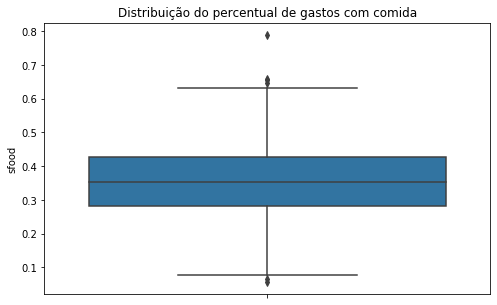

In [46]:
## plotando um boxplot
fig, axs = plt.subplots(ncols=1, figsize = (8,5))

ax0 = sns.boxplot(y="sfood", data=df)
ax0.set_title("Distribuição do percentual de gastos com comida")

In [32]:
## estimando a equação; quanto maior o total de gastos, menor a proporção gasta com comida (aumento de 10% nos gastos totais diminui a proporção gast com comida em ≈1,46%)
exog = df[['ltotexpend','age','kids']]
endog = None
instrumentos = None
y = df['sfood']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y, cov='robust')

                            OLS Estimation Summary                            
Dep. Variable:                  sfood   R-squared:                      0.2862
Estimator:                        OLS   Adj. R-squared:                 0.2848
No. Observations:                1519   F-statistic:                    589.55
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:43   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.8959     0.0291     30.750     0.0000      0.8388      0.9530
ltotexpend    -0.1459     0.0062    -23.400     0.00

In [33]:
## usando lincome como vi de ltotexpend; lincome é muito significante, satisfazendo a condição de relevancia
exog = df[['lincome','age','kids']]
endog = None
instrumentos = None
y = df['ltotexpend']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y, cov='robust')

                            OLS Estimation Summary                            
Dep. Variable:             ltotexpend   R-squared:                      0.2563
Estimator:                        OLS   Adj. R-squared:                 0.2548
No. Observations:                1519   F-statistic:                    407.44
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:43   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9223     0.1312     14.653     0.0000      1.6652      2.1795
lincome        0.4778     0.0284     16.798     0.00

In [34]:
## estimando a equação estrutural com lincome como vi de ltotexpend; a estimativa de ltotexpend é quase a mesma (1% mais negativa), apesar do diametro do IC ser bastante maior e conter a estimativa de MQO. De fato, parece que ltotexpend é exógena
exog = df[['age','kids']]
endog = df[['ltotexpend']]
instrumentos = df[['lincome']]
y = df['sfood']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y, cov='robust')

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  sfood   R-squared:                      0.2837
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2822
No. Observations:                1519   F-statistic:                    188.48
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:43   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.9523     0.0540     17.629     0.0000      0.8464      1.0582
age            0.0019     0.0003     6.1526     0.00

In [35]:
## testando se ltotexpend é exog; não podemos rejeitar a hipótese de que ltotexpend é exógena, ou seja, prefere-se estimar por MQO
## não há nenhuma restrição sobreidentificadora para ser testada
print(Resultado.wooldridge_regression)

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 1.3057
P-value: 0.2532
Distributed: chi2(1)


In [36]:
## ao invés de sfood, usando salcohol
# MQO
exog = df[['ltotexpend','age','kids']]
endog = None
instrumentos = None
y = df['salcohol']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y, cov='robust')

                            OLS Estimation Summary                            
Dep. Variable:               salcohol   R-squared:                      0.0549
Estimator:                        OLS   Adj. R-squared:                 0.0530
No. Observations:                1519   F-statistic:                    80.623
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:44   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0091     0.0189     0.4800     0.6312     -0.0279      0.0460
ltotexpend     0.0276     0.0041     6.6710     0.00

In [37]:
# MQ2E; as estimativas de ltotexpend agora são positivas, indicando que o álcool é um bem não-essencial e de luxo (renda-elástico)
exog = df[['age','kids']]
endog = df[['ltotexpend']]
instrumentos = df[['lincome']]
y = df['salcohol']

Regressao_IV_MQ2E(exog=exog, endog=endog, instrumentos=instrumentos, y=y, cov='robust')

                          IV-2SLS Estimation Summary                          
Dep. Variable:               salcohol   R-squared:                      0.0547
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0529
No. Observations:                1519   F-statistic:                    53.092
Date:                Mon, Apr 05 2021   P-value (F-stat)                0.0000
Time:                        22:14:44   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const      -1.983e-05     0.0403    -0.0005     0.9996     -0.0789      0.0789
age           -0.0015     0.0002    -6.4359     0.00